# Contraceptive Use in Indonesia: 1987 Study #

## Source: UCI Machine Learning Repository ##
### URL: [WebLink](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice)


Source:

** Origin: **
- This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey 

** Creator and Donor: **
- [Tjen-Sien Lim](limt@stat.wisc.edu) 

** Relevant Papers:**
- [Lim, T.-S., Loh, W.-Y. & Shih, Y.-S. (1999). A Comparison of Prediction Accuracy, Complexity, and Training Time of Thirty-three Old and New Classification Algorithms. Machine Learning](http://www.stat.wisc.edu/~loh/treeprogs/guide/mach1317.pdf)

In [1]:
from contra_tools.file_retrieve import *
from data_tools.log_reg import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
import bokeh as bk
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper, Slider
from bokeh.io import curdoc, show, output_notebook, push_notebook, output_file
from bokeh.layouts import widgetbox, column, row, gridplot
from bokeh.plotting import figure

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.externals import joblib

np.set_printoptions(suppress=True)

%matplotlib inline
plt.style.use('bmh')

pink_green = 'PiYG'
paired_colors = 'Paired'


##for CatColorMapper, 
''' 
CatColMap = CategoricalColorMapper(factors =[], palette = [])
Hover = HoverTool(tooltips=[('string label','@column_name')])

plot.add_tools(Hover)
plot.circle(x,y,source=source,color={'field':[column_name],'transform':[CatColMap]})'''

##for gridplot,
'''
layout = gridplot(list of rows)
gridplot shares the toolbar for all plots
'''

##for callbacks,
'''
def callback(attr,old,new):
    [insert Slider function]
    
slider.on_change('value',callback)
'''

##for bokeh server,
'''
curdoc().add_root(layout)

in the shell:

bokeh serve --show myapplication.py
'''

'\ncurdoc().add_root(layout)\n\nin the shell:\n\nbokeh serve --show myapplication.py\n'

In [2]:
'''1. Wife's age                     (numerical)
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical)
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use 
                                                        2=Long-term
                                                        3=Short-term'''

print('Let\'s make some algorithmic magic!')

Let's make some algorithmic magic!


In [3]:
df = make_df()

In [4]:
df.tail()

,wife_age,wife_edu,husb_edu,num_child,wife_islam,wife_unemployed,husb_occupation,life_std,bad_media,contra_type
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3
1472,17,3,3,1,1,1,2,4,0,3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
wife_age           1473 non-null int64
wife_edu           1473 non-null int64
husb_edu           1473 non-null int64
num_child          1473 non-null int64
wife_islam         1473 non-null int64
wife_unemployed    1473 non-null int64
husb_occupation    1473 non-null int64
life_std           1473 non-null int64
bad_media          1473 non-null int64
contra_type        1473 non-null int64
dtypes: int64(10)
memory usage: 115.2 KB


[]

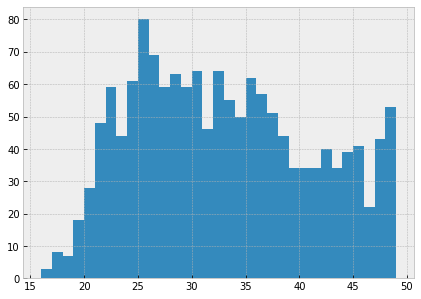

In [6]:
age_range = df.wife_age.max() - df.wife_age.min()

df.wife_age.hist(bins=age_range,figsize=(7,5))
plt.plot()

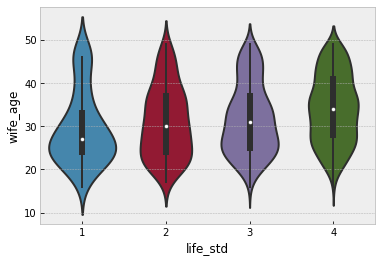

In [7]:
sb.violinplot(x='life_std',y='wife_age',data=df)

#### Binning the # children and age to prep for one-hot encoding

In [8]:
df['num_children'] = pd.cut(df['num_child'],[-1,1,3,6,max(df['num_child'])],labels=['[0-1]','(1-3]','(3-6]','(6-{}]'.format(max(df['num_child']))])

In [9]:
df['num_children'].value_counts()

(1-3]     535
(3-6]     424
[0-1]     373
(6-16]    141
Name: num_children, dtype: int64

In [10]:
df['wife_range'] = pd.cut(df['wife_age'].astype('int64'),bins=[0,24,30,37,43,max(df['wife_age'])],labels=['[18-24]','(24-29]','(29-37]','(37-43]','(43-{}]'.format(max(df['wife_age']))])

In [11]:
df['wife_range'].value_counts()

(24-29]    394
(29-37]    385
[18-24]    276
(37-43]    220
(43-49]    198
Name: wife_range, dtype: int64

In [12]:
df_2 = pd.crosstab(df['wife_range'],df['num_children'],normalize='index')
df_2

num_children,[0-1],(1-3],(3-6],(6-16]
wife_range,,,,
[18-24],0.601449,0.355072,0.043478,0.000000
(24-29],0.314721,0.467005,0.200508,0.017766
(29-37],0.088312,0.394805,0.428571,0.088312
(37-43],0.100000,0.286364,0.422727,0.190909
(43-49],0.136364,0.191919,0.378788,0.292929


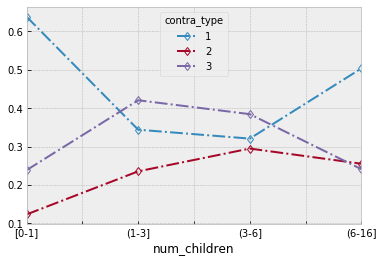

In [13]:
df_3 = pd.crosstab(df['num_children'],df['contra_type'],normalize='index')
df_3.plot(marker='d',markerfacecolor='none',linestyle='-.')

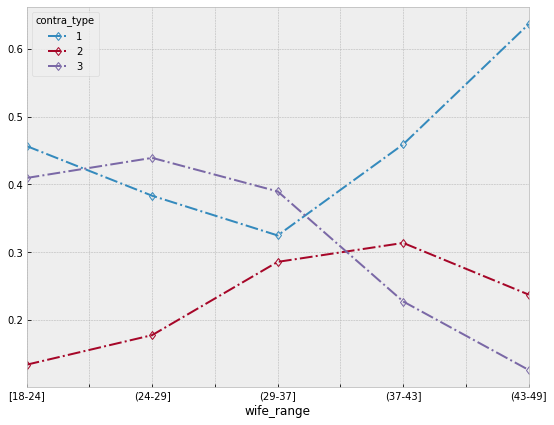

In [14]:
df_4 = pd.crosstab(df['wife_range'],df['contra_type'],normalize='index')
df_4.plot(marker='d',markerfacecolor='none',linestyle='-.',figsize=(9,7))

- Normalized the frequency counts due to the discrepancy in population. When looking at raw totals, it appears as though contraceptive type 1 decreases with age, but the proportion of women using no contraception actually appears to increase after around age 37.

In [15]:
df.drop(['wife_age','num_child'],axis=1,inplace=True)

In [16]:
for c in ['wife_edu','husb_edu','husb_occupation','life_std','contra_type']:
    df[c] = df[c].astype('category')

In [17]:
df_dummies = pd.get_dummies(df)
df_dummies.head()

,wife_islam,wife_unemployed,bad_media,wife_edu_1,wife_edu_2,wife_edu_3,wife_edu_4,husb_edu_1,husb_edu_2,husb_edu_3,...,contra_type_3,num_children_[0-1],num_children_(1-3],num_children_(3-6],num_children_(6-16],wife_range_[18-24],wife_range_(24-29],wife_range_(29-37],wife_range_(37-43],wife_range_(43-49]
0,1,1,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
1,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,1,1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,1,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [18]:
def reorder_df(df,list_of_targets=None):
    #quick function to change column order in dataframe
    
    if list_of_targets is None:
        list_of_targets = ['contra_type_1','contra_type_2','contra_type_3']

    columns = list(df.columns)
    
    for i in list_of_targets:
        columns.pop(columns.index(i))
        columns.append(i)

    df = df.loc[:,columns]
    return df

In [19]:
df_dummies = reorder_df(df_dummies)

In [20]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 31 columns):
wife_islam             1473 non-null int64
wife_unemployed        1473 non-null int64
bad_media              1473 non-null int64
wife_edu_1             1473 non-null uint8
wife_edu_2             1473 non-null uint8
wife_edu_3             1473 non-null uint8
wife_edu_4             1473 non-null uint8
husb_edu_1             1473 non-null uint8
husb_edu_2             1473 non-null uint8
husb_edu_3             1473 non-null uint8
husb_edu_4             1473 non-null uint8
husb_occupation_1      1473 non-null uint8
husb_occupation_2      1473 non-null uint8
husb_occupation_3      1473 non-null uint8
husb_occupation_4      1473 non-null uint8
life_std_1             1473 non-null uint8
life_std_2             1473 non-null uint8
life_std_3             1473 non-null uint8
life_std_4             1473 non-null uint8
num_children_[0-1]     1473 non-null uint8
num_children_(1-3]     1473 non-n

In [21]:
df_features = df_dummies.iloc[:,:-3]
df_targets = df_dummies.iloc[:,-3:]

In [22]:
features_matrix = df_features.as_matrix()
targets_matrix = df_targets.as_matrix()

## Testing Gradient Descent ##
### Target Variable: Contraceptive Type 1 (No Contraceptive)

- Keep in mind, this is not a final prediction
- No train/test split, just to peek at which factors have greatest influence on classification

In [23]:
weights = np.zeros(features_matrix.shape[1])
targets = targets_matrix[:,0]

row_list = []

for i in range(1000):
    prediction_proba = sigmoid(np.dot(features_matrix,weights))
    
    weights_gradient = np.dot(features_matrix.T,(prediction_proba-targets)) / features_matrix.shape[0]
    
    weights = weights - (weights_gradient*0.1)
    
    predictions = np.round(prediction_proba)
    
    row_list.append([*weights,roc_auc_score(targets,prediction_proba),log_loss(prediction_proba,targets),accuracy_score(targets,predictions)])
    
    if i % 100 == 0:
        print(round(sum(predictions==targets)/len(targets_matrix[:,0]),5))
        
    ##early stopping: if AUC does not improve/change more than 0.1% between 50 loops, then loop is broken
        
    if i > 50:
        if abs((row_list[i][-3] - row_list[i-50][-3]) / row_list[i][-3]) < 0.0001:
            break
        
gradient_df = pd.DataFrame(row_list)

0.57298
0.67957
0.69179
0.6945
0.70129
0.69925
0.70536
0.70333
0.70265
0.70265


In [24]:
columns_list = list(df_features.columns)
columns_list.extend(('auc_score','log_loss','accuracy_score'))

In [25]:
top_auc_score = gradient_df.loc[:,28].idxmax(axis=1)

In [26]:
best_weights_for_loss= [(x,y) for x,y in zip(gradient_df.iloc[top_auc_score,].values,columns_list)]

In [27]:
best_weights_for_loss

[(0.20095338067552573, 'wife_islam'),
 (-0.20460235355056089, 'wife_unemployed'),
 (0.4559028257718612, 'bad_media'),
 (0.55217568193346889, 'wife_edu_1'),
 (0.33527960478373969, 'wife_edu_2'),
 (-0.08021798839129303, 'wife_edu_3'),
 (-0.76900929895317971, 'wife_edu_4'),
 (0.19029262033411412, 'husb_edu_1'),
 (-0.04062977564892311, 'husb_edu_2'),
 (-0.13226517537585017, 'husb_edu_3'),
 (0.020830330063394624, 'husb_edu_4'),
 (0.053630525525743447, 'husb_occupation_1'),
 (0.15256531273960733, 'husb_occupation_2'),
 (-0.056194444826306492, 'husb_occupation_3'),
 (-0.11177339406630847, 'husb_occupation_4'),
 (0.32422245187196841, 'life_std_1'),
 (0.080756189046482782, 'life_std_2'),
 (-0.09865194947969913, 'life_std_3'),
 (-0.26809869206601733, 'life_std_4'),
 (1.1909171898951885, 'num_children_[0-1]'),
 (-0.17506876910570013, 'num_children_(1-3]'),
 (-0.66118960339339505, 'num_children_(3-6]'),
 (-0.31643081802335599, 'num_children_(6-16]'),
 (-0.56619771987678691, 'wife_range_[18-24]'),


In [28]:
best_weights_for_loss_sorted = sorted(best_weights_for_loss[:-3],key= lambda x: x[0],reverse=True)

### Sanity Checks###

** Positive contributing factors to non-use of contraception: **

In [29]:
best_weights_for_loss_sorted[:5]

[(1.1909171898951885, 'num_children_[0-1]'),
 (0.90850466593558299, 'wife_range_(43-49]'),
 (0.55217568193346889, 'wife_edu_1'),
 (0.4559028257718612, 'bad_media'),
 (0.36133816474397989, 'wife_range_(37-43]')]

** Negative contributing factors to non-use of contraception: **

In [30]:
best_weights_for_loss_sorted[-5:]

[(-0.31643081802335599, 'num_children_(6-16]'),
 (-0.44377729394129922, 'wife_range_(24-29]'),
 (-0.56619771987678691, 'wife_range_[18-24]'),
 (-0.66118960339339505, 'num_children_(3-6]'),
 (-0.76900929895317971, 'wife_edu_4')]

In [31]:
bern = BernoulliNB(alpha=0.1)

In [32]:
bern.fit(features_matrix,targets_matrix[:,0])

BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)

In [33]:
sum(bern.predict(features_matrix) == targets_matrix[:,0]) / len(targets_matrix[:,0])

0.65241004752206377

- Is my homemade function/ for-loop outperforming out of the box Bernoulli NB??

### Optimize with regularization? ##

- Going to try two methods and see their effect on predictions:
    1. L-1 (RIDGE): Add weights' Sum of Squares multiplied by a lambda constant to avoid over-fitting
    2. L-2 (LASSO): Add weights' Sum of Absolute Values multiplied by lambda constant, which reduces less important factors to zero (feature selection)

### Train/Test Split ###

In [34]:
X_train, X_test, y_train, y_test = train_test_split(features_matrix,df_targets)

## Testing the Homemade classsifier: Standard, Ridge, and LASSO

### Standard (No Normalization)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_features,df_targets)

In [36]:
clf_std = BinaryClassifier()

In [37]:
clf_std.fit(X_train,y_train)

fitting to target contra_type_1...
fitting to target contra_type_2...
fitting to target contra_type_3...
Complete!


In [38]:
clf_std.predict(X_test)

In [39]:
y_test.columns

Index(['contra_type_1', 'contra_type_2', 'contra_type_3'], dtype='object')

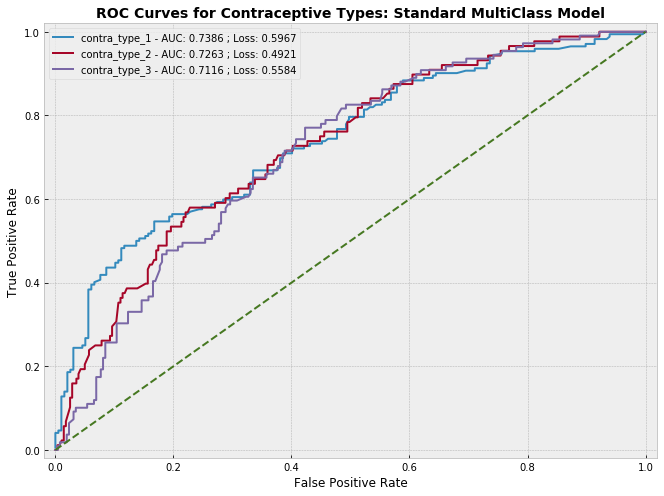

In [40]:
plt.figure(figsize=(11,8))

for i, v in enumerate(list(y_test.columns)):
    
    loss = log_loss(clf_std.probabilities_matrix.iloc[:,i].values,y_test.iloc[:,i].values)
    
    auc = roc_auc_score(y_test.iloc[:,i].values,clf_std.probabilities_matrix.iloc[:,i].values)
    
    fpr, tpr, thres = roc_curve(y_test.iloc[:,i].values,clf_std.probabilities_matrix.iloc[:,i].values)
    
    _ = plt.plot(fpr, tpr, label = '{} - AUC: {} ; Loss: {}'.format(v,round(auc,4),round(loss,4)))

plt.plot(np.linspace(0,1,20),np.linspace(0,1,20),linestyle='--')
plt.title('ROC Curves for Contraceptive Types: Standard MultiClass Model',fontsize=14,fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.margins(0.02)
plt.legend(loc=0)
plt.show()

- On a standard model, contraceptive type 1 yields the best results, which is perhaps not surprising given its prevalence throughout the data.

### Weights by Target, as determined by Standard Classifier

In [41]:
df_weights = pd.DataFrame(clf_std.fitted_weights,columns=df_features.columns,index=df_targets.columns)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000008737065D68>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000008738381D68>], dtype=object)

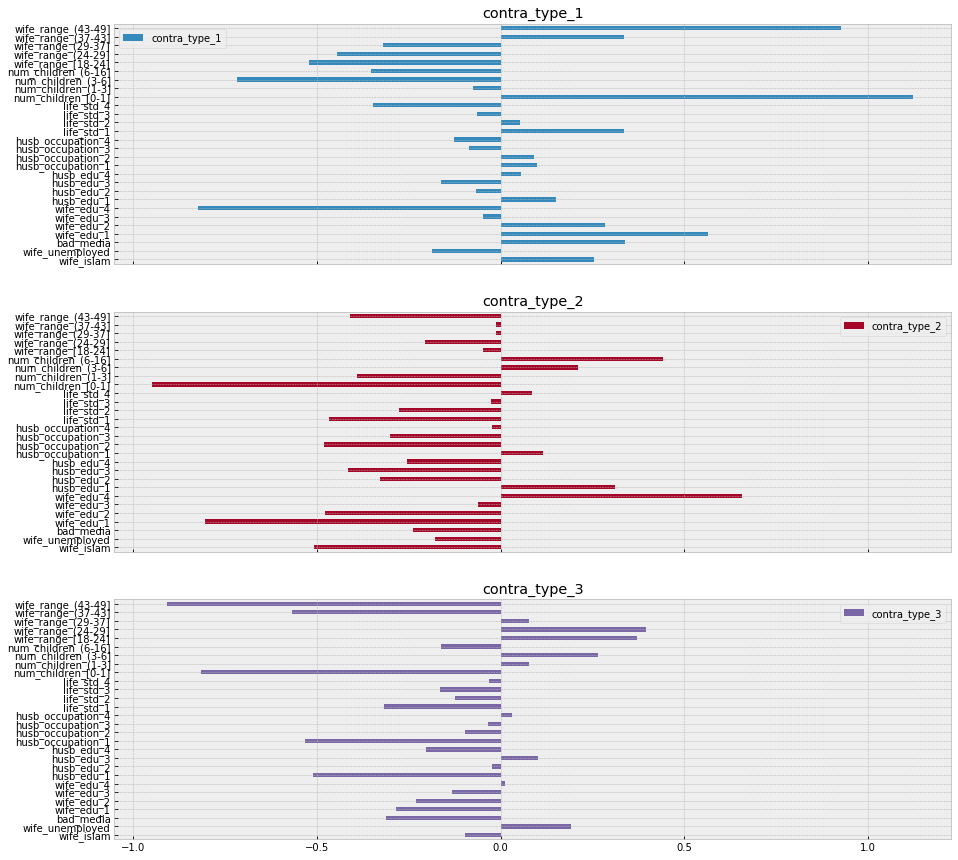

In [42]:
df_weights.T.plot(kind='barh',subplots=True,figsize=(15,15),sharey=True,sharex=True)

In [43]:
df_weights.T['contra_type_1'].nlargest(5)

num_children_[0-1]    1.122426
wife_range_(43-49]    0.927085
wife_edu_1            0.563934
bad_media             0.339913
wife_range_(37-43]    0.336312
Name: contra_type_1, dtype: float64

In [44]:
df_weights.T['contra_type_2'].nlargest(5)

wife_edu_4             0.656410
num_children_(6-16]    0.441418
husb_edu_1             0.310569
num_children_(3-6]     0.211175
husb_occupation_1      0.116867
Name: contra_type_2, dtype: float64

In [45]:
df_weights.T['contra_type_3'].nlargest(5)

wife_range_(24-29]    0.395466
wife_range_[18-24]    0.370650
num_children_(3-6]    0.266258
wife_unemployed       0.191509
husb_edu_3            0.102394
Name: contra_type_3, dtype: float64

### Model with Ridge Regularization

In [46]:
clf_ridge = BinaryClassifier(regularization={'ridge':.1})

In [47]:
clf_ridge.fit(X_train,y_train)

fitting to target contra_type_1...
fitting to target contra_type_2...
fitting to target contra_type_3...
Complete!


In [48]:
clf_ridge.predict(X_test)

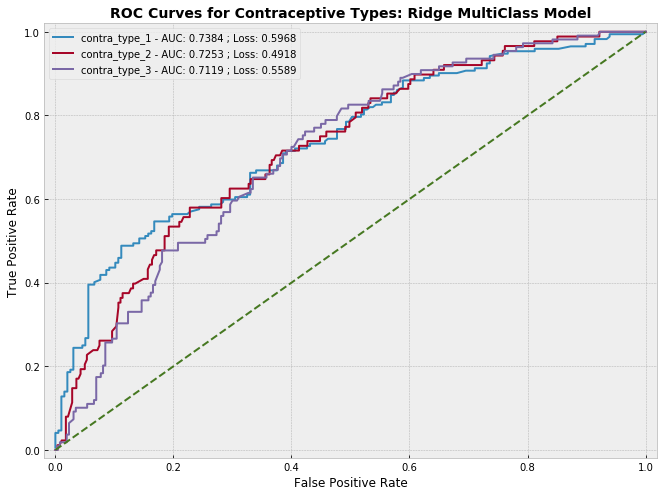

In [49]:
plt.figure(figsize=(11,8))

for i, v in enumerate(list(y_test.columns)):
    
    loss = log_loss(clf_ridge.probabilities_matrix.iloc[:,i].values,y_test.iloc[:,i].values)
    
    auc = roc_auc_score(y_test.iloc[:,i].values,clf_ridge.probabilities_matrix.iloc[:,i].values)
    
    fpr, tpr, thres = roc_curve(y_test.iloc[:,i].values,clf_ridge.probabilities_matrix.iloc[:,i].values)
    
    _ = plt.plot(fpr, tpr, label = '{} - AUC: {} ; Loss: {}'.format(v,round(auc,4),round(loss,4)))

plt.plot(np.linspace(0,1,20),np.linspace(0,1,20),linestyle='--')
plt.title('ROC Curves for Contraceptive Types: Ridge MultiClass Model',fontsize=14,fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.margins(0.02)
plt.legend(loc=0)
plt.show()

In [50]:
df_weights_2 = pd.DataFrame(clf_ridge.fitted_weights,columns=df_features.columns,index=df_targets.columns)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000087385117F0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000008739E2DE48>], dtype=object)

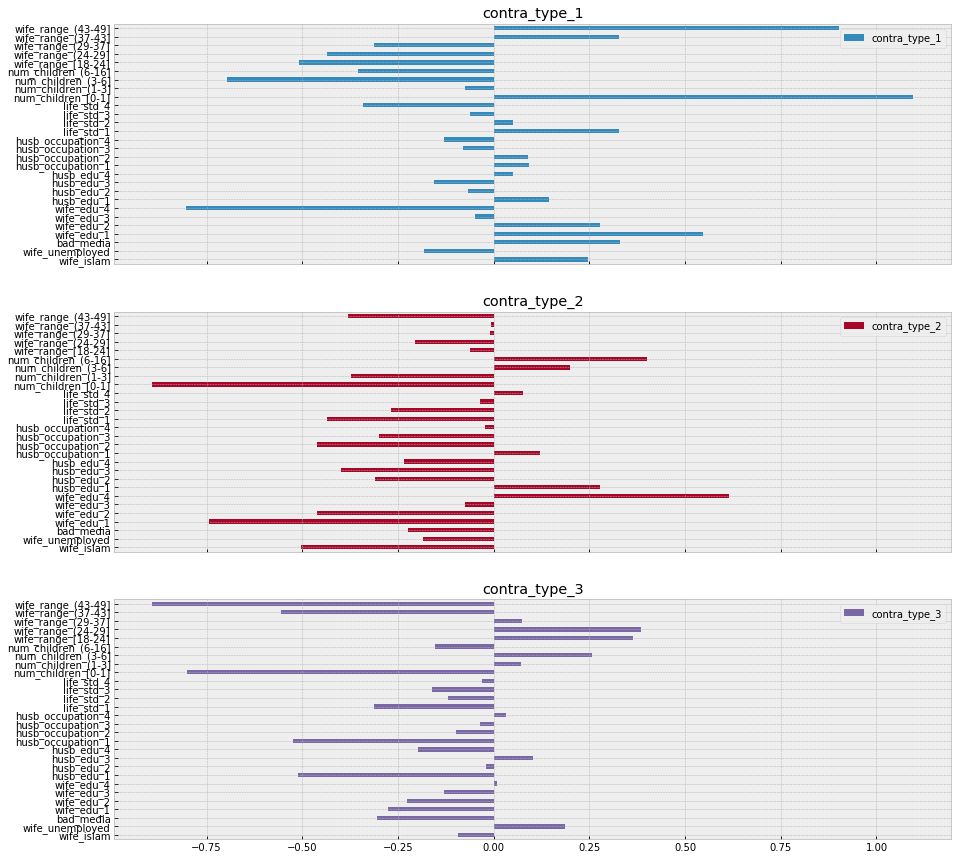

In [51]:
df_weights_2.T.plot(kind='barh',subplots=True,figsize=(15,15),sharey=True,sharex=True)

### LASSO Regression

In [52]:
clf_lasso = BinaryClassifier(regularization={'lasso':0.07})

In [53]:
clf_lasso.fit(X_train,y_train)

fitting to target contra_type_1...
fitting to target contra_type_2...
fitting to target contra_type_3...
Complete!


In [54]:
clf_lasso.predict(X_test)

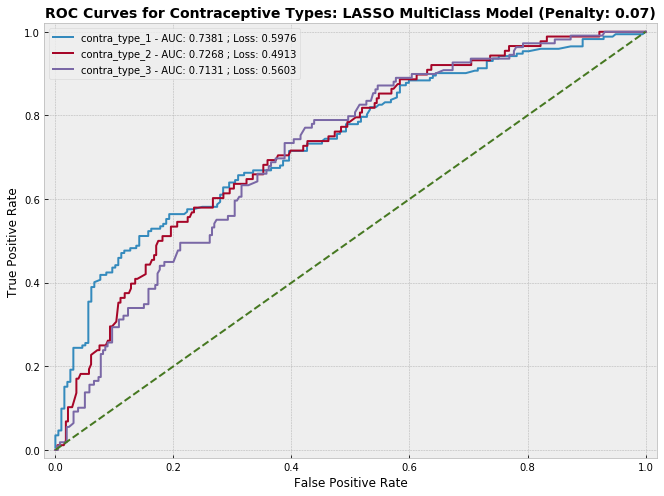

In [55]:
plt.figure(figsize=(11,8))

for i, v in enumerate(list(y_test.columns)):
    
    loss = log_loss(clf_lasso.probabilities_matrix.iloc[:,i].values,y_test.iloc[:,i].values)
    
    auc = roc_auc_score(y_test.iloc[:,i].values,clf_lasso.probabilities_matrix.iloc[:,i].values)
    
    fpr, tpr, thres = roc_curve(y_test.iloc[:,i].values,clf_lasso.probabilities_matrix.iloc[:,i].values)
    
    _ = plt.plot(fpr, tpr, label = '{} - AUC: {} ; Loss: {}'.format(v,round(auc,4),round(loss,4)))

plt.plot(np.linspace(0,1,20),np.linspace(0,1,20),linestyle='--')
plt.title('ROC Curves for Contraceptive Types: LASSO MultiClass Model (Penalty: {})'.format(clf_lasso.penalty_lambda_),fontsize=14,fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.margins(0.02)
plt.legend(loc=0)
plt.show()

In [56]:
df_weights_3 = pd.DataFrame(clf_lasso.fitted_weights,columns=df_features.columns,index=df_targets.columns)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000873A7D7F28>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000087385EE898>], dtype=object)

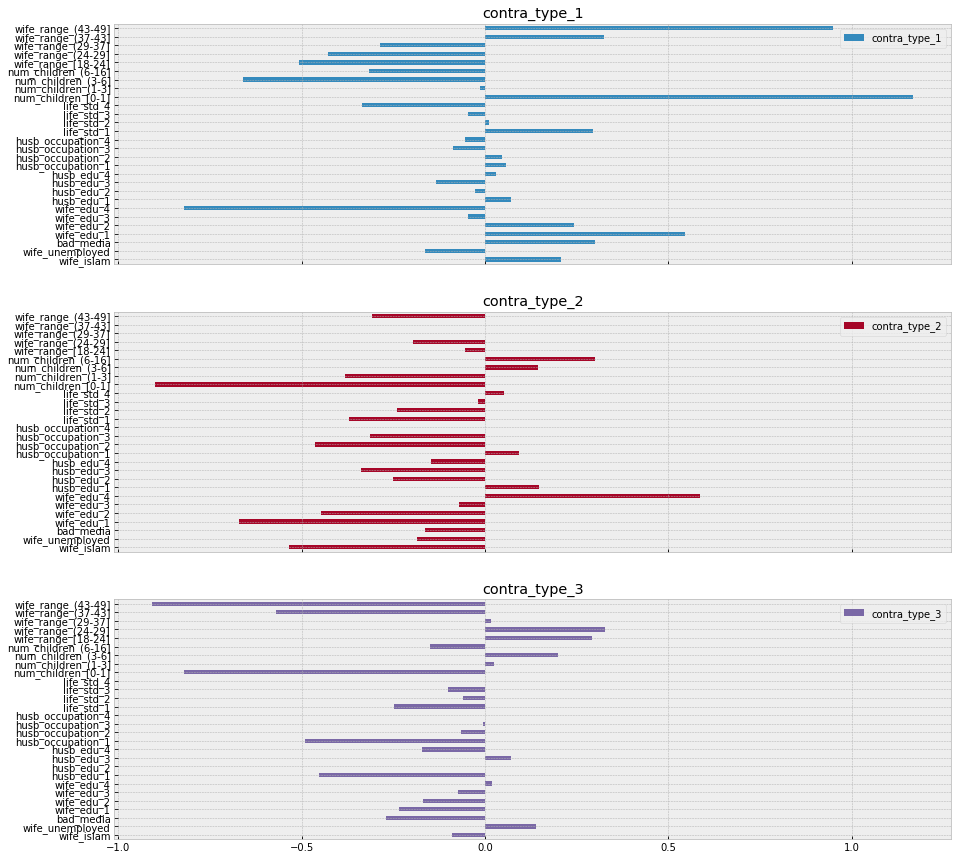

In [57]:
df_weights_3.T.plot(kind='barh',subplots=True,figsize=(15,15),sharey=True,sharex=True)

In [58]:
logreg = LogisticRegression(C=1)

In [59]:
ovrc = OneVsRestClassifier(logreg)

In [60]:
ovrc.fit(X_train,y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [61]:
probabilities_df = pd.DataFrame(ovrc.predict_proba(X_test))

In [62]:
rounded_predictions = probabilities_df.idxmax(axis=1)

In [63]:
ones_rounded_predictions = pd.get_dummies(rounded_predictions)

In [64]:
auc_scores_ovrc = [roc_auc_score(y_test.iloc[:,i],probabilities_df.iloc[:,i].values) for i in range(y_test.shape[1])]

In [65]:
auc_scores_ovrc

[0.73578975327588236, 0.71922516984794571, 0.71787226534932957]

In [66]:
probabilities_df.head()

,0,1,2
0,0.734853,0.071597,0.167104
1,0.178734,0.544165,0.327417
2,0.412974,0.165325,0.269078
3,0.615180,0.083038,0.321025
4,0.088743,0.734007,0.317331


In [67]:
clf_std.probabilities_matrix.head()

,contra_type_1,contra_type_2,contra_type_3
0,0.734105,0.090205,0.189502
1,0.195841,0.550419,0.354447
2,0.440239,0.127226,0.435667
3,0.602660,0.084087,0.308101
4,0.128118,0.490649,0.515259


In [68]:
ovrc.coef_

array([[ 0.40251105, -0.15857171,  0.37804624,  0.6569727 ,  0.3084484 ,
        -0.09910338, -0.99985257,  0.0738152 , -0.13803145, -0.17365956,
         0.10434095,  0.18815789,  0.20566108, -0.00745933, -0.51989451,
         0.35509025,  0.01127887, -0.09616766, -0.40373632,  1.38017998,
         0.01092905, -0.80484026, -0.71980363, -0.82860562, -0.60497717,
        -0.29125389,  0.44493803,  1.14636379],
       [-0.51031923, -0.16606021, -0.13649841, -1.22098933, -0.31309526,
         0.181822  ,  0.9683706 ,  1.02940141, -0.37609956, -0.57920705,
        -0.45798679,  0.15965041, -0.44397155, -0.24762572,  0.14805486,
        -0.58669652, -0.14270191,  0.10577122,  0.23973521, -1.01541447,
        -0.37370717,  0.30176417,  0.70346547,  0.15431769, -0.08236407,
         0.02494993, -0.00181094, -0.4789846 ],
       [-0.00190583,  0.24353729, -0.35017841, -0.17525485, -0.2527483 ,
        -0.14372483,  0.06083338, -1.21347525,  0.24128444,  0.3784837 ,
         0.0828125 , -0.5756

In [69]:
ovrc_weights = pd.DataFrame(ovrc.coef_,columns=df_features.columns,index=df_targets.columns)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000873A921F28>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000087387B2358>], dtype=object)

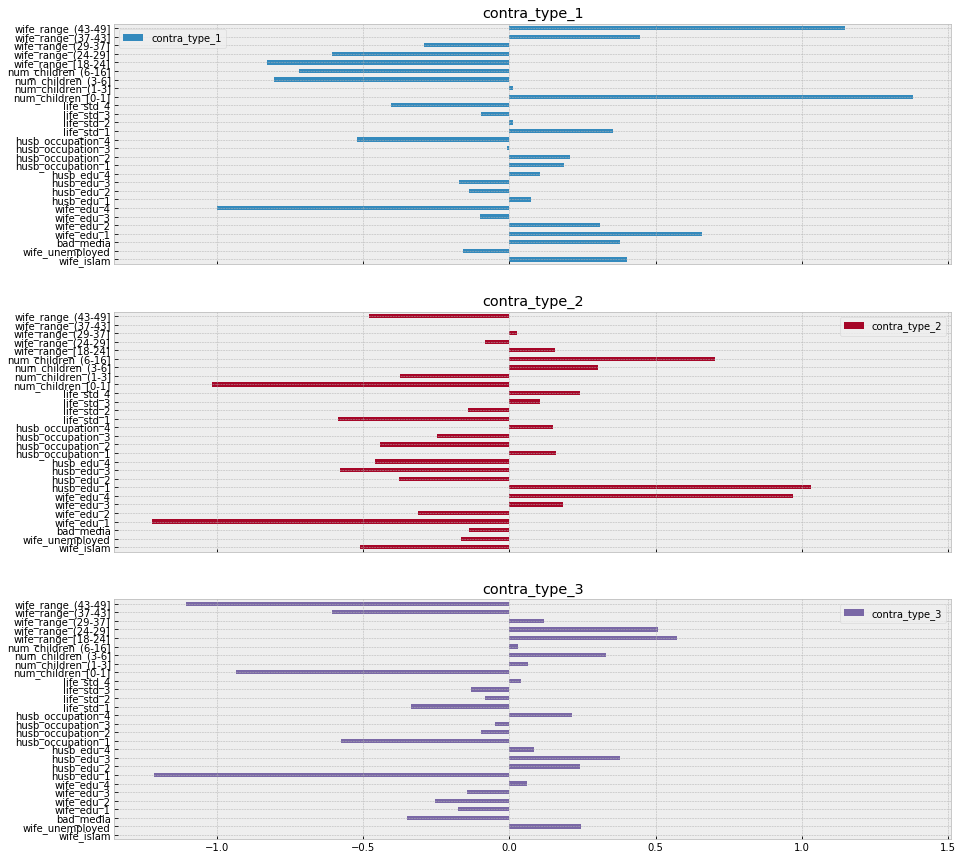

In [70]:
ovrc_weights.T.plot(kind='barh',subplots=True,figsize=(15,15),sharey=True,sharex=True)

In [71]:
diff_between_models = ovrc.coef_ - clf_std.fitted_weights

In [72]:
diff_weights = pd.DataFrame(diff_between_models,columns=df_features.columns,index=df_targets.columns)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000873A9B2898>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000873AAB6E48>], dtype=object)

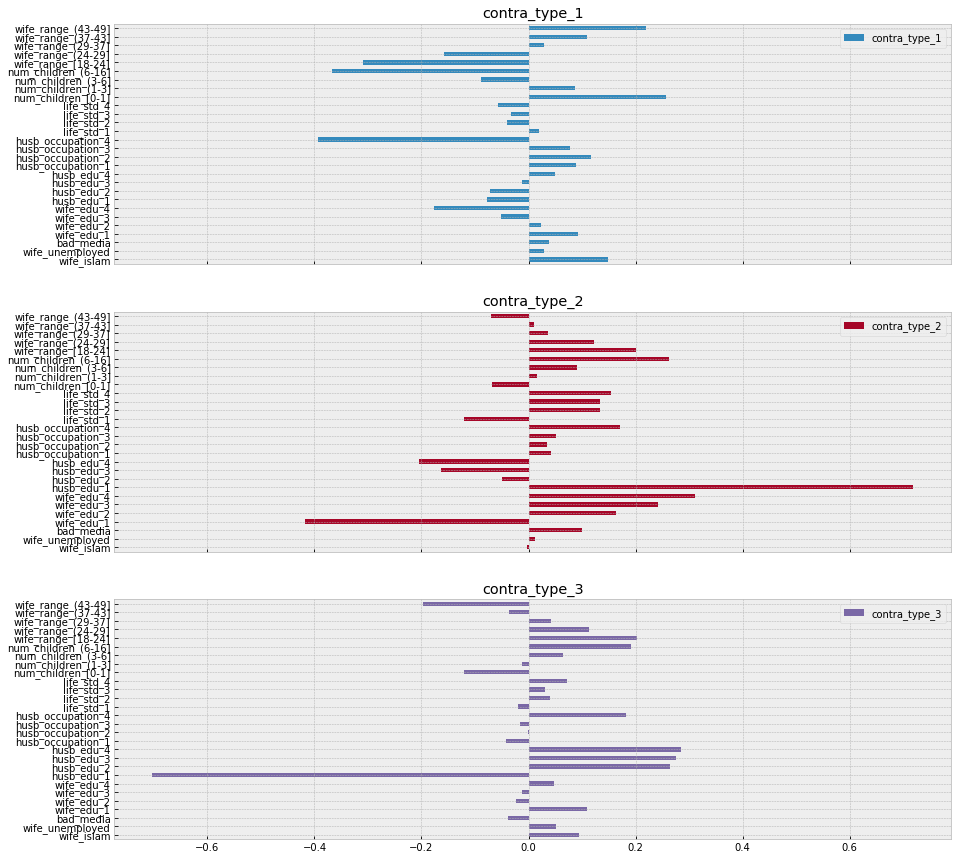

In [73]:
diff_weights.T.plot(kind='barh',subplots=True,figsize=(15,15),sharey=True,sharex=True)

In [74]:
clf_std.fitted_weights

array([[ 0.25379772, -0.18774566,  0.33991339,  0.56393376,  0.28550964,
        -0.04853332, -0.82329651,  0.15062257, -0.0663214 , -0.16123324,
         0.05454564,  0.09862639,  0.08974993, -0.08502965, -0.12573309,
         0.33612633,  0.05231015, -0.0631892 , -0.34763371,  1.12242564,
        -0.07512377, -0.71672877, -0.35295953, -0.52004424, -0.44612992,
        -0.31960887,  0.33631195,  0.92708465],
       [-0.50707129, -0.17736031, -0.23695622, -0.80329318, -0.47721286,
        -0.06106244,  0.65640981,  0.31056925, -0.32703878, -0.41532062,
        -0.25336852,  0.11686673, -0.47910352, -0.29963847, -0.02328342,
        -0.46653046, -0.27625839, -0.02711826,  0.08474844, -0.94743698,
        -0.39031483,  0.21117532,  0.44141782, -0.04741974, -0.20437387,
        -0.01197864, -0.01196349, -0.40942292],
       [-0.09691482,  0.19150948, -0.31262583, -0.28496192, -0.22959085,
        -0.13088511,  0.01256099, -0.51031028, -0.02279721,  0.10239423,
        -0.20216363, -0.5331

In [75]:
joblib.dump(ovrc,'contraception_onevsmany_classifier.pkl')

['contraception_onevsmany_classifier.pkl']

In [76]:
clf_std.save_model('contraception_custom_classifier.pkl')

In [77]:
contra = joblib.load('contraception_custom_classifier.pkl')

In [78]:
contra_2 = clf_std.load_model()

In [79]:
contra_2 = clf_std.load_model()

In [80]:
contra_2.fitted_weights

array([[ 0.25379772, -0.18774566,  0.33991339,  0.56393376,  0.28550964,
        -0.04853332, -0.82329651,  0.15062257, -0.0663214 , -0.16123324,
         0.05454564,  0.09862639,  0.08974993, -0.08502965, -0.12573309,
         0.33612633,  0.05231015, -0.0631892 , -0.34763371,  1.12242564,
        -0.07512377, -0.71672877, -0.35295953, -0.52004424, -0.44612992,
        -0.31960887,  0.33631195,  0.92708465],
       [-0.50707129, -0.17736031, -0.23695622, -0.80329318, -0.47721286,
        -0.06106244,  0.65640981,  0.31056925, -0.32703878, -0.41532062,
        -0.25336852,  0.11686673, -0.47910352, -0.29963847, -0.02328342,
        -0.46653046, -0.27625839, -0.02711826,  0.08474844, -0.94743698,
        -0.39031483,  0.21117532,  0.44141782, -0.04741974, -0.20437387,
        -0.01197864, -0.01196349, -0.40942292],
       [-0.09691482,  0.19150948, -0.31262583, -0.28496192, -0.22959085,
        -0.13088511,  0.01256099, -0.51031028, -0.02279721,  0.10239423,
        -0.20216363, -0.5331

## Conclusion: ##

### Key Contributing Factors:

In [81]:
weights_transformed = df_weights.T

In [104]:
for c in weights_transformed.columns:
    
    top, bottom = list(weights_transformed[c].nlargest(5).index), list(weights_transformed[c].nsmallest(5).index)
    
    print(c,": \nTop Contributing Factors: \n")
    
    for i, t in enumerate(top):
        print(t)
    
    print('\nTop Counteracting Factors: \n')
    
    for i in bottom:
        print(i)
        
    print(' \n')
   

contra_type_1 : 
Top Contributing Factors: 

num_children_[0-1]
wife_range_(43-49]
wife_edu_1
bad_media
wife_range_(37-43]

Top Counteracting Factors: 

wife_edu_4
num_children_(3-6]
wife_range_[18-24]
wife_range_(24-29]
num_children_(6-16]
 

contra_type_2 : 
Top Contributing Factors: 

wife_edu_4
num_children_(6-16]
husb_edu_1
num_children_(3-6]
husb_occupation_1

Top Counteracting Factors: 

num_children_[0-1]
wife_edu_1
wife_islam
husb_occupation_2
wife_edu_2
 

contra_type_3 : 
Top Contributing Factors: 

wife_range_(24-29]
wife_range_[18-24]
num_children_(3-6]
wife_unemployed
husb_edu_3

Top Counteracting Factors: 

wife_range_(43-49]
num_children_[0-1]
wife_range_(37-43]
husb_occupation_1
husb_edu_1
 



- Generally, Number of Children and wife's age were most important factors in conctraceptive choice
- Marriage partner status and religion had a smaller role than perhaps expected
- It is clear that long term contraception is generally a result of higher education, whereas short term contraception has more to do with lifestyle choice of young women, 18-29.